In [1]:
import obspy as os
import obspy.signal
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from obspy import clients

import matplotlib.pyplot as plt
from obspy.taup import TauPyModel
from obspy.geodetics import locations2degrees
from scipy.io import wavfile
import IPython.display as ipd

In [2]:
from obspy import UTCDateTime

#This is a dictionary 

big_events = { "Japan_2011": { "start_time": UTCDateTime("2011-03-11T05:46:23"), 
                              "latitude": 38.297, "longitude": 142.372, "depth_km": 29
                             },
               "Alaska_2021": { "start_time": UTCDateTime("2021-07-29T06:15:49"),
                                "latitude": 55.325,"longitude": -157.972, "depth_km": 32
                              },
               "Russia_2025": {"start_time": UTCDateTime("2025-07-25T00:15:30"),
                               "latitude": 54.000, "longitude": 160.0000, "depth_km": 25
                              }
            }

# This shows a network and station pairing 
                # so AF is the network while ["AAUS", "ANKE", "DESE", "EKNA", "IFE", "KAD", "NSU"] is the station. 
                # This applies to the rest for clarity
network_stations = {
                        "AF": ["AAUS", "ANKE", "DESE", "EKNA", "IFE", "KAD", "NSU"],
                        "AU": ["MCQ"],
                        "G": ["ATD", "TAM"],
                        "IM": ["TOA1", "TOA2", "TOA3", "TOB1", "TOB2", "TOB3", "TOB4", "TOB5", "TORD"],
                        "IP": ["MTOR"],
                        "IU": ["FURI", "MACI"],
                        "NJ": ["AWK", "IFE", "KAD", "NSU", "TORO"],
                        "NZ": ["CTZ"]
}

In [3]:
client = Client('IRIS')
model = TauPyModel(model = "ak135")      # In the dropdown menu we can have models using either models "iasp91", "ak135", "ak135f", "prem"


selected_event = "Japan_2011"  #There should be a dropdown for selected events: Japan_2011, Alaska_2021 and Russia_2025
selected_network = "IU"        #I don't know how this will be connected to networ_stations, i don't know how 
selected_station = "PAYG"
selected_channel = "BHZ"       # We can have a drop down for three channels(BH1, BH2, BHZ), for now maybe just focu
selected_location = "*"        # Thwill serve as a wildcat (*), you can use various wildcat tho in the drop down, 
                               # eg BH?, LH?

event = big_events[selected_event]
start_time = event["start_time"]
end_time = start_time + 10000
event_lat = event["latitude"]
event_lon = event["longitude"]
event_depth_km = event["depth_km"]

In [4]:
try:
    st = client.get_waveforms(selected_network, selected_station, selected_location,
                              selected_channel, start_time, end_time, attach_response=True
                             )
    st_rem = st.copy()
    st_rem.remove_response(output="VEL")
    st_rem.detrend('linear')
    st_rem.detrend('demean')
    tr = st_rem[0]
except Exception as e:
    print(f"There was a download error, please check inputs Maybe incorrect channel, station and network name Ensure your input is correct and well written: {e}")

In [5]:
inv = client.get_stations( network=selected_network, station=selected_station,
                           level="station", starttime=start_time, endtime=end_time
                         )
sta = inv[0][0]
station_lat = sta.latitude
station_lon = sta.longitude
distance_deg = locations2degrees(event_lat, event_lon, station_lat, station_lon)

In [6]:
# I neeed a drop down for the the filter ranges

filter_ranges = [(0.03, 0.10), 
                 (0.03, 0.15), 
                 (0.03, 0.20), 
                 (0.04, 0.1), 
                 (0.04, 0.15)]      

    
phase_types = ["P", "S", "SKS", "SKKS"]   
                                                    #This part shows the TauP phases we wanna overlay on the plots
                                                    # What this does that is shows the body waves(P&S) arrival amongst others
arrival_colors = {'P': 'r', 
                  'S': 'g', 
                  'SKS': 'b', 
                  'SKKS': 'm'}

colors = [
            'k', 'r', 'b', 'g',                   
            'orange','purple',         
            'cyan','magenta',     
            'brown','olive',
            'teal','pink','gold'
            'darkred', 'navy',  
        ]

0.03 0.1


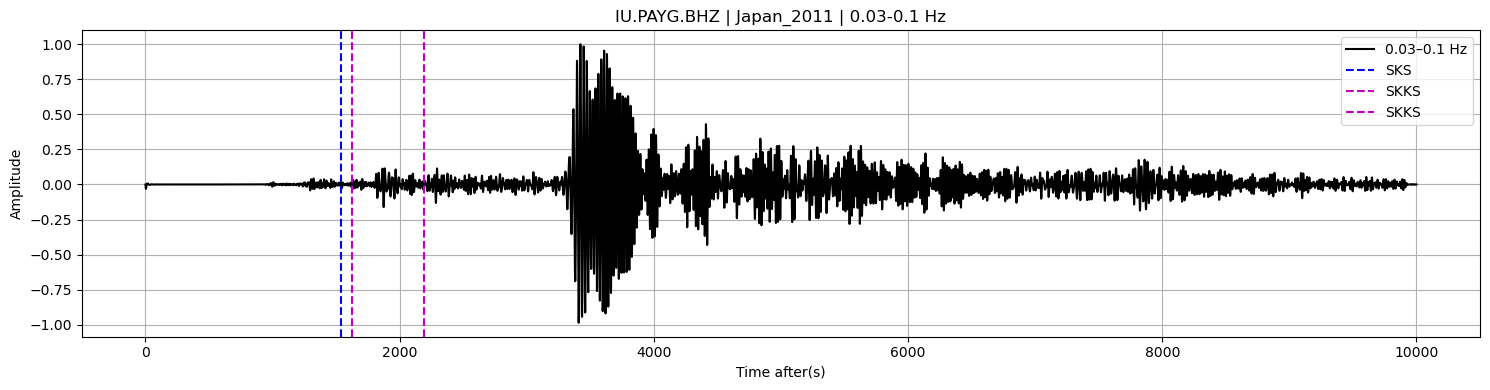

(0.0, 1000.0)

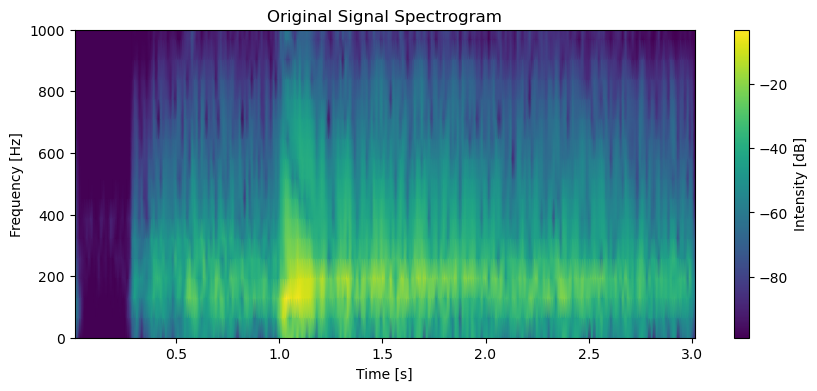

In [7]:
from scipy.signal import spectrogram
import numpy as np

## Just get the first waveform and spectrogram
i = 0
fmin, fmax = filter_ranges[0]

print(fmin, fmax)

tr_filt = tr.copy()
tr_filt.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)
tr_filt.data = tr_filt.data / max(abs(tr_filt.data))
t = tr_filt.times("relative")

arrivals = model.get_travel_times(
    source_depth_in_km=event_depth_km,
    distance_in_degree=distance_deg,
    phase_list=phase_types
)
color = colors[i % len(colors)]  

plt.figure(figsize=(15, 4))
plt.plot(t, tr_filt.data, label=f'{fmin}–{fmax} Hz', color=color)
plt.xlabel("Time after(s)")
plt.ylabel("Amplitude")
plt.title(f"{selected_network}.{selected_station}.{selected_channel} | {selected_event} | {fmin}-{fmax} Hz")

for arr in arrivals:
    if arr.name in arrival_colors:
        plt.axvline(arr.time, color=arrival_colors[arr.name], linestyle='--', label=arr.name)

plt.grid(True)
if i == 0:
    plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Plot the spectrogram in dB
sampling_rate = tr_filt.stats.sampling_rate
sampling_rate = 66150

plt.figure(figsize=(10, 4))
frequencies, time_segments, Sxx = spectrogram(tr_filt.data, fs=sampling_rate, nperseg=1024, noverlap=256, scaling='spectrum')
plt.pcolormesh(time_segments, frequencies, 10 * np.log10(Sxx + 1e-10), shading='gouraud', cmap='viridis', vmin=-99)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('Original Signal Spectrogram')
plt.colorbar(label='Intensity [dB]')
plt.ylim(0, 1000)

In [8]:
quake_name = tr_filt.stats.network + tr_filt.stats.station + tr_filt.stats.location + tr_filt.stats.channel
print(quake_name)

IUPAYG00BHZ


In [10]:
wavfile.write(f'{quake_name}.wav', sampling_rate, np.array(tr_filt.data, dtype=np.float32))
ipd.Audio(f'{quake_name}.wav')

In [11]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, Audio
import matplotlib.pyplot as plt
import numpy as np

audio_sampling_rate = int(sampling_rate)
audio_data = np.array(tr_filt.data, dtype=np.float32)
duration = len(audio_data) / audio_sampling_rate
times = np.linspace(0, duration, len(audio_data))


In [13]:

fig, ax = plt.subplots(figsize=(10, 3))
ax.set_xlim(0, duration)
ax.set_ylim(-1.1, 1.1)
line, = ax.plot([], [], lw=2, color='k')
ax.set_title('Seismic Waveform Playback')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Amplitude')

# Init function
def init():
    line.set_data([], [])
    return line,

# Animation function
window_size = 2  # seconds shown in the moving window
step = 0.05  # seconds per frame

def animate(i):
    start = i * int(step * audio_sampling_rate)
    end = start + int(window_size * audio_sampling_rate)
    if end > len(times):
        end = len(times)
    x = times[start:end]
    y = audio_data[start:end]
    line.set_data(x, y)
    ax.set_xlim(x[0], x[-1])
    return line,

# Total frames for the whole audio duration
num_frames = int(duration / step)

ani = FuncAnimation(fig, animate, frames=num_frames, init_func=init,
                    blit=True, interval=step * 1000)

plt.close()  

In [14]:
HTML(ani.to_jshtml()) 
Audio(data=audio_data, rate=audio_sampling_rate)  # Play sound